In [1]:
from datetime import datetime
import os
import requests
import bz2
import xarray as xr
import metpy
import pandas as pd
from utils import * 
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from matplotlib.colors import BoundaryNorm

projection = euratl


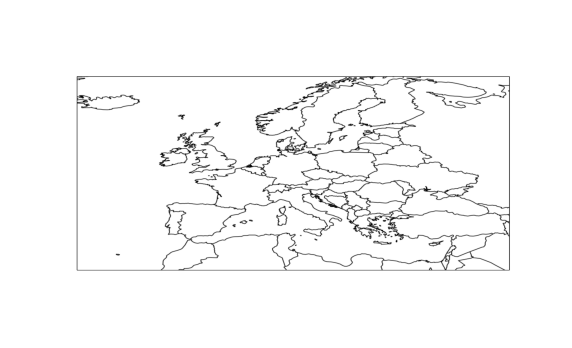

In [22]:
fig = plt.figure(figsize=(figsize_x, figsize_y))
ax = get_projection_cartopy(plt, 'euratl', regions=False, compute_projection=False)
plt.savefig('euratl_background.png', bbox_inches='tight')

In [ ]:
%%time
dset = get_dset(vars_2d=['t_2m'], f_times=list(np.arange(1, 79)) )

In [2]:
urls = find_file_name(vars_2d=['t_2m'],
                     f_times=list(np.arange(1, 79)))
fils = download_extract_files(urls)

In [14]:
dset = get_dset(vars_3d=['t@850','fi@500'], f_times=[0, 2])

In [83]:
def get_dset(vars_2d=None, vars_3d=None, f_times=0):
    if vars_2d is not None or vars_3d is not None:
        urls = find_file_name(vars_2d=vars_2d,
                              vars_3d=vars_3d,
                              f_times=f_times)
        fils = download_extract_files(urls)
        ds = xr.open_mfdataset(fils, engine='cfgrib', preprocess=preprocess,
                  combine="by_coords", concat_dim='valid_time', parallel=True)

    return ds

projection = euratl
ipykernel_launcher.py : Pre-processing finished, launching plotting scripts
CPU times: user 1.16 s, sys: 136 ms, total: 1.3 s
Wall time: 1.11 s


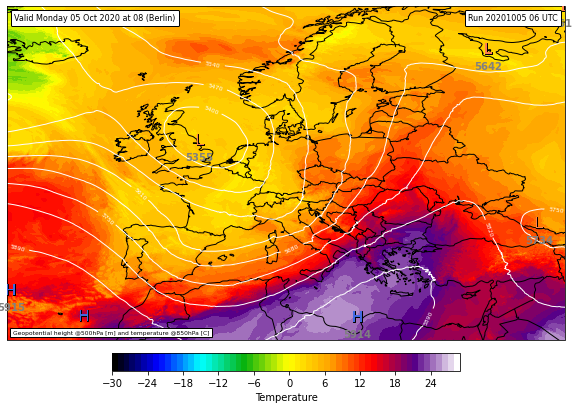

In [13]:
%%time
variable_name = 'gph_t_850'
projection='euratl'

dset = get_dset(vars_3d=['t@850','fi@500']).squeeze()
cum_hour =  dset.step.values.astype(int)
time = pd.to_datetime(dset.valid_time.values)

# Select 850 hPa level using metpy
temp_850 = dset['t']
temp_850.metpy.convert_units('degC')
z_500 = dset['z']
gph_500 = mpcalc.geopotential_to_height(z_500)
gph_500 = xr.DataArray(gph_500, coords=z_500.coords,
                       attrs={'standard_name': 'geopotential height',
                              'units': gph_500.units})

levels_temp = np.arange(-30., 30., 1.)
levels_gph = np.arange(4700., 6000., 70.)

cmap = get_colormap('temp')

fig = plt.figure(figsize=(figsize_x, figsize_y))

temp_850, gph_500 = subset_arrays([temp_850, gph_500], projection)

lon, lat = get_coordinates(temp_850)
lon2d, lat2d = np.meshgrid(lon, lat)

ax = get_projection_cartopy(plt, projection, regions=False, compute_projection=True)

# All the arguments that need to be passed to the plotting function
print_message('Pre-processing finished, launching plotting scripts')

# Build the name of the output image
filename = projection + '_' + variable_name + '_%s.png' % cum_hour

if projection == 'euratl':
    norm = BoundaryNorm(levels_temp, ncolors=cmap.N)
    cs = ax.pcolormesh(lon2d, lat2d, temp_850, cmap=cmap, norm=norm)
else:
    cs = ax.contourf(lon2d, lat2d, temp_850, extend='both', cmap=cmap, levels=levels_temp)

c = ax.contour(lon2d, lat2d, gph_500, levels=levels_gph, colors='white', linewidths=1.)

labels = ax.clabel(c, c.levels, inline=True, fmt='%4.0f', fontsize=6)

maxlabels = plot_maxmin_points(ax, lon, lat, gph_500,
                               'max', 80, symbol='H', color='royalblue', random=True)
minlabels = plot_maxmin_points(ax, lon, lat, gph_500,
                               'min', 80, symbol='L', color='coral', random=True)

an_fc = annotation_forecast(ax, time)
an_var = annotation(
    ax, 'Geopotential height @500hPa [m] and temperature @850hPa [C]', loc='lower left', fontsize=6)
an_run = annotation_run(ax, time)

plt.colorbar(cs, orientation='horizontal',
             label='Temperature', pad=0.03, fraction=0.04)